In [3]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import time
import random


In [4]:
import json

def load_data(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data
data=load_data('MentalhealthcareData.json')

In [5]:
!pip install spacy
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
nlp = spacy.load('en_core_web_md')

In [7]:

def advanced_preprocess_text(text):
    doc = nlp(text.lower())
    cleaned_text = []
    skip_next = False
    for token in doc:
        if skip_next:
            skip_next = False
            continue
        if token.text == 'not' and token.i + 1 < len(doc):
            cleaned_text.append(token.text + '_' + doc[token.i + 1].lemma_)
            skip_next = True
        elif not token.is_stop and not token.is_punct and token.lemma_ != "-PRON-":
            if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
                cleaned_text.append(token.lemma_)
    return " ".join(cleaned_text)

# Example use:
text_example = "I am not feeling well Today."
processed_text = advanced_preprocess_text(text_example)
print(processed_text)  # Check output to see if it makes sense and isn't single characters


not_feel today


In [8]:
# Preprocess patterns in intents
for intent in data['intents']:
  intent['processed_pattern']   = advanced_preprocess_text(intent['pattern'])

In [9]:
for intent in data['intents'][:5]:
    original_text = intent['pattern']
    preprocessed_text =  intent['processed_pattern']
    print(f"Original: {original_text}\nPreprocessed: {preprocessed_text}\n")

Original: How do I navigate cultural differences with my partner's family?
Preprocessed: navigate cultural difference partner family

Original: What should I do if my partner and I have different levels of emotional intelligence?
Preprocessed: partner different level emotional intelligence

Original: How can I support my partner through a career transition?
Preprocessed: support partner career transition

Original: What should I do if my partner and I have different parenting styles?
Preprocessed: partner different parenting style

Original: How do I handle disagreements about money with my partner?
Preprocessed: handle disagreement money partner



In [10]:
#Convert JSON data into Dataframe
df = pd.json_normalize(data['intents'])




In [11]:
df.head()

,tag,pattern,response,processed_pattern
0,relationship,How do I navigate cultural differences with my...,Navigating cultural differences with your part...,navigate cultural difference partner family
1,relationship,What should I do if my partner and I have diff...,Differences in emotional intelligence can impa...,partner different level emotional intelligence
2,relationship,How can I support my partner through a career ...,Supporting your partner through a career trans...,support partner career transition
3,relationship,What should I do if my partner and I have diff...,Differences in parenting styles can lead to co...,partner different parenting style
4,relationship,How do I handle disagreements about money with...,Disagreements about money are common in relati...,handle disagreement money partner


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tag                780 non-null    object
 1   pattern            780 non-null    object
 2   response           780 non-null    object
 3   processed_pattern  780 non-null    object
dtypes: object(4)
memory usage: 24.5+ KB


In [13]:
df.describe()


,tag,pattern,response,processed_pattern
count,780,780,780,780
unique,300,729,746,713
top,anxiety,What is postpartum psychosis?,Treatment for conduct disorder may include the...,postpartum psychosis
freq,49,4,2,4


# Model Training

In [14]:
# Define the augment_data function
def augment_data(df, multiplier=5):
    augmented_data = pd.concat([df] * multiplier, ignore_index=True)
    return augmented_data

**Logistic Regression**

In [15]:

def train_and_evaluate_lr(data_file):


    # Data Augmentation (Example: Duplicate existing samples)
    augmented_df = pd.concat([df] * 5, ignore_index=True)  # Duplicate each sample 5 times

    # Combine original and augmented data
    combined_df = pd.concat([df, augmented_df], ignore_index=True)

    # Split the Combined Data
    X_train, X_test, y_train, y_test = train_test_split(combined_df['processed_pattern'], combined_df['response'], test_size=0.3, random_state=42)
    start_time = time.time()
    # Define a pipeline with TF-IDF Vectorizer and Logistic Regression Classifier (a simpler model)
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression Classifier
    ])


    # Train the pipeline
    pipeline.fit(X_train, y_train)

    end_time = time.time()

    time_lr = end_time - start_time
      # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return pipeline, accuracy, time_lr


In [16]:

def predict_input_lr(pipeline, user_input):
    predicted_response = pipeline.predict([user_input])[0]
    return predicted_response

# Example usage:
trained_pipeline_lr, accuracy_lr, time_lr= train_and_evaluate_lr(df)
print("Accuracy:", accuracy_lr)
print("Computation Time:",time_lr)


Accuracy: 0.7378917378917379
Computation Time: 14.855388402938843


**Support Vector Machine**

In [17]:
def train_and_evaluate_svm(data_file):

    # Load your dataset
    df = data_file

    # Data Augmentation (Example: Duplicate existing samples)
    augmented_df = pd.concat([df] * 5, ignore_index=True)  # Duplicate each sample 5 times

    # Combine original and augmented data
    combined_df = pd.concat([df, augmented_df], ignore_index=True)

    # Split the Combined Data
    X_train, X_test, y_train, y_test = train_test_split(combined_df['processed_pattern'], combined_df['response'], test_size=0.3, random_state=42)

    # Define a pipeline with TF-IDF Vectorizer and SVM Classifier with a non-linear kernel
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
        ('classifier', SVC(kernel='rbf', C=1.0))  # SVM Classifier with a non-linear kernel
    ])
    start_time = time.time()
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    end_time = time.time()

    time_svm = end_time - start_time
    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return pipeline, accuracy, time_svm




In [18]:
def predict_input_svm(pipeline, user_input):
    predicted_response = pipeline.predict([user_input])[0]
    return predicted_response
# def predict_input_svm(model, user_input, threshold=0.5):
#     decision = model.decision_function([user_input])[0]
#     max_decision = max(decision)
#     predicted_response = model.predict([user_input])[0]
#     if max_decision < threshold:
#         return "I'm not sure. Can you please rephrase?"
#     else:
#         return predicted_response

trained_pipeline_svm, accuracy_svm , time_svm = train_and_evaluate_svm(df)
print("Accuracy:", accuracy_svm)
print("Computation Time:",time_svm)





Accuracy: 0.9273504273504274
Computation Time: 5.910269260406494


**Decision Tree**

In [19]:

# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['processed_pattern'], augmented_df['response'], test_size=0.3, random_state=42)


# Define a pipeline with TF-IDF Vectorizer and Decision Tree Classifier
pipeline_DTree = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', DecisionTreeClassifier(random_state=42))  # Decision Tree Classifier
])
start_time = time.time()
# Train the pipeline
pipeline_DTree.fit(X_train, y_train)
end_time = time.time()
time_dt = end_time - start_time
# Predict on test data
y_pred = pipeline_DTree.predict(X_test)



In [20]:
# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_dt)

print("Computation Time:",time_dt)

# Function to predict response
def predict_response(user_input):
    predicted_response = pipeline_DTree.predict([user_input])[0]
    return predicted_response


Accuracy: 0.9333333333333333
Computation Time: 3.2111477851867676


**Random forest classifier**

In [21]:
# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['processed_pattern'], augmented_df['response'], test_size=0.3, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier()
start_time = time.time()
# Train the Random Forest Classifier
rf_classifier.fit(X_train_tfidf, y_train)
end_time = time.time()
time_rf = end_time - start_time


In [22]:
# Predict on test data
y_pred_rf = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy for Random Forest Classifier
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Classifier Accuracy:", accuracy_rf)
print("Computation Time:",time_rf)

Random Forest Classifier Accuracy: 0.9333333333333333
Computation Time: 9.166960954666138


**KNN model**

In [23]:
# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['processed_pattern'], augmented_df['response'], test_size=0.3, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize KNN Classifier
knn_classifier = KNeighborsClassifier()
start_time = time.time()
# Train the KNN Classifier
knn_classifier.fit(X_train_tfidf, y_train)
end_time = time.time()
time_knn = end_time - start_time


In [24]:
# Predict on test data
y_pred_knn = knn_classifier.predict(X_test_tfidf)

# Calculate accuracy for KNN Classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Classifier Accuracy:", accuracy_knn)
print("Computation Time:",time_knn)

KNN Classifier Accuracy: 0.7247863247863248
Computation Time: 0.008637666702270508


# Accurancy graph

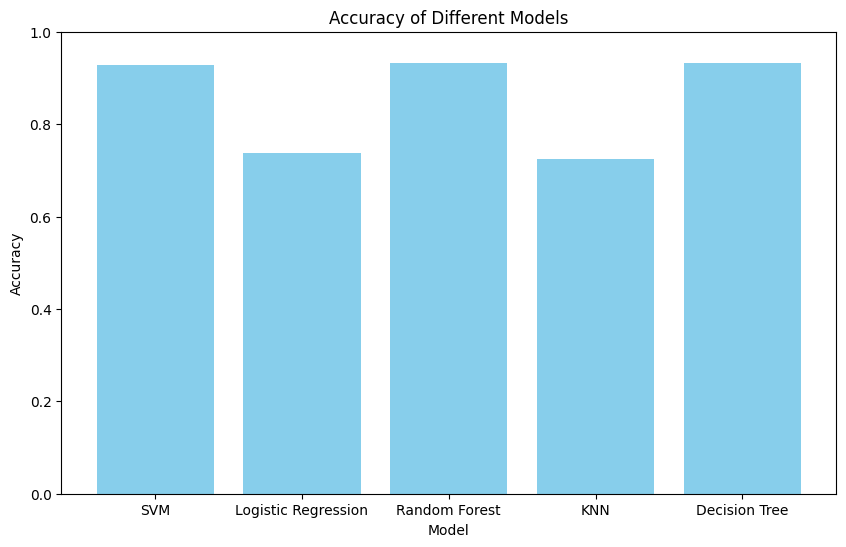

In [25]:
# List of model names
models = ['SVM', 'Logistic Regression', 'Random Forest', 'KNN', 'Decision Tree']

# List of accuracies for each model
accuracies = [accuracy_svm, accuracy_lr, accuracy_rf, accuracy_knn, accuracy_dt]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.0, 1.0)  # Set the y-axis limit from 0 to 1
plt.show()

# Computation graph

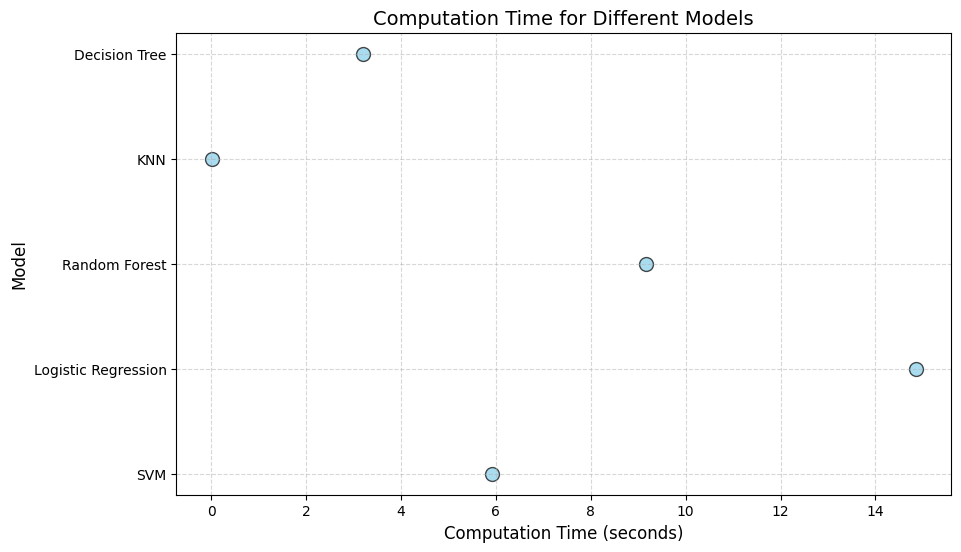

In [26]:
# List of computation times for each model (replace with actual times)
computation_times = [time_svm, time_lr, time_rf, time_knn, time_dt]
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6))
plt.scatter(computation_times, models, color='skyblue', edgecolor='black', s=100, alpha=0.7)
plt.xlabel('Computation Time (seconds)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Computation Time for Different Models', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

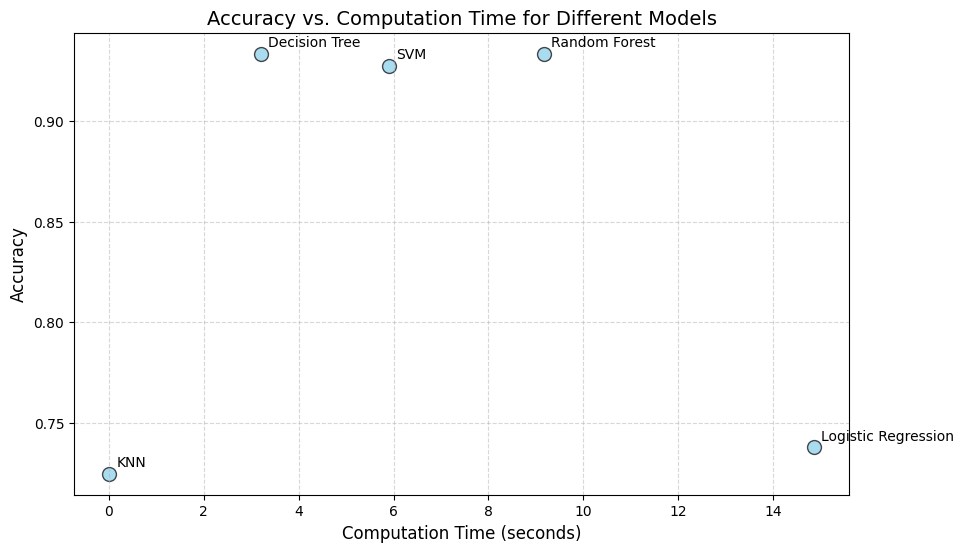

In [27]:
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6))
plt.scatter(computation_times, accuracies, color='skyblue', edgecolor='black', s=100, alpha=0.7)
plt.xlabel('Computation Time (seconds)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs. Computation Time for Different Models', fontsize=14)
for model, time, accuracy in zip(models, computation_times, accuracies):
    plt.annotate(model, (time, accuracy), xytext=(5, 5), textcoords='offset points', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [28]:
# Fun responses
fun_responses = [
    "I'm feeling a bit binary today. 0s and 1s.",
    "Why did the computer go to the doctor? It had a virus!",
    "I told my computer I needed a break, and it froze!",
    "I'm reading a book on anti-gravity. It's impossible to put down!",
    "Why don't programmers like nature? It has too many bugs!",
    "I'm so good at sleeping, I can do it with my eyes closed.",
    "I'm not lazy, I'm just in energy-saving mode.",
    "I'm not a fan of computer jokes. Not one bit!",
    "I'm reading a book about anti-gravity. It's out of this world!",
    "I'm a big fan of whiteboards. They're re-markable!",
]

In [29]:
def chatbot():
    print("Chatbot: Hello! I'm your mental health care assistant. Let's talk about how you're feeling today.")
    user_name = input("Chatbot: Before we begin, may I know your name please? ")

    # Welcome the user by name
    print(f"Chatbot: Nice to meet you, {user_name}! How can I assist you today? Type 'exit' to end our conversation.")

    while True:
        # Take the user's input
        user_input = input(f"{user_name}: ")

        # Check if the user wants to exit the conversation
        if user_input.lower() in ['exit', 'quit']:
            print(f"Chatbot: Thank you for talking with me, {user_name}. Take care!")
            break

        # Check if the user wants to hear a joke or motivational quote
        if 'joke' in user_input.lower():
            response = random.choice(fun_responses)
        else:
            # Predict the response using the SVM model
            response = predict_input_svm(trained_pipeline_svm, user_input)

        print(f"Chatbot: {response}")


In [30]:
# Call the chatbot function to start the conversation
chatbot()

Chatbot: Hello! I'm your mental health care assistant. Let's talk about how you're feeling today.
Chatbot: Before we begin, may I know your name please? exit
Chatbot: Nice to meet you, exit! How can I assist you today? Type 'exit' to end our conversation.
exit: exit
Chatbot: Thank you for talking with me, exit. Take care!


In [32]:
import joblib

# Save model
joblib.dump(trained_pipeline_svm, 'svm_model.joblib')

# Save vectorizer
# joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


['svm_model.joblib']